In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from mnist_model import generator,discriminator
import utils

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Hyperparam

In [2]:
params = dict(
    batch_size = 100,
    seed = 1234,
    z_dim = 100,
    x_dim = 784,
    reg_w = 0.,
    lr = 2e-4
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data creation

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels

# trainx = 2.*trainx-1.
trainx = np.reshape(trainx,[-1,28,28,1])
testx = np.reshape(testx,[-1,28,28,1])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


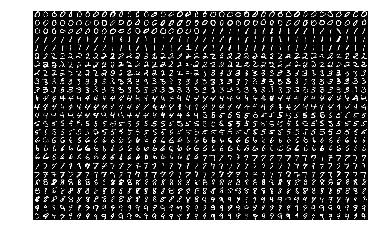

In [4]:
labeled =100
trainx_unl = trainx.copy()
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']

show_digits(trainx[:1000])
plt.show()

## Build model

In [5]:
tf.reset_default_graph()

In [6]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['batch_size'])

train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params['batch_size'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params['batch_size'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
training_init_op = iterator.make_initializer(train_dataset)
validation_init_op = iterator.make_initializer(test_dataset)

iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

In [7]:
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
# Construct generator and discriminator net
samples = generator(noise,is_training_pl,reuse=False)
real_score = discriminator(data,is_training_pl,reuse=False)
fake_score = discriminator(samples,is_training_pl,reuse=True)

In [8]:
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.zeros_like(fake_score)))

optimizer_dis = tf.train.AdamOptimizer(learning_rate=params['lr'],
                                               beta1=0.5, name='dis_optimizer')
optimizer_gen = tf.train.AdamOptimizer(learning_rate=params['lr'],
                                               beta1=0.5, name='gen_optimizer')

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS,
                                   scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS,
                                   scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer_gen.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer_dis.minimize(loss_d,var_list=disc_vars)

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

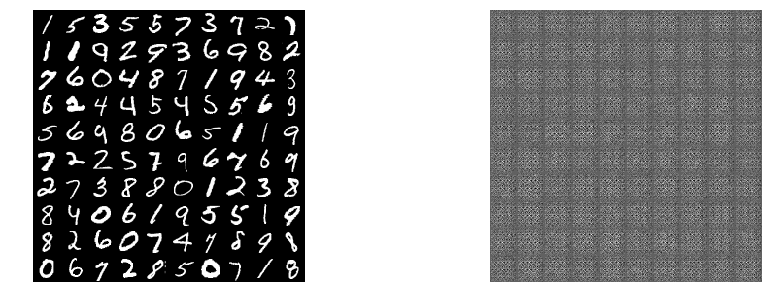

KeyboardInterrupt: 

In [10]:
fs = []
frames = []
np_samples = []
n_batches_viz = 1
viz_every = 100
lsd=[]
lsg=[]
for i in tqdm(range(20000)):
#     f, _= sess.run([[loss], train_op],{is_training_pl:True})
    ld,_=sess.run([loss_d,traind],{is_training_pl:True})
    lg,_=sess.run([loss_g, traing],{is_training_pl:True})
    lsd.append(ld); lsg.append(lg);

    if (i) % viz_every == 0:
        xx, yy = sess.run([data,samples],{is_training_pl:False})
#         print('iter nr : ',gstep)
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        show_digits(xx[:100])
        plt.subplot(122)
        show_digits(yy[:100])
        plt.show()


## classifier

In [12]:
params_dnn = dict(
    epsilon = .005,
    gamma = 6., #2.
    eta = 0.15,
    batch = 10,
    mc_batch = 2000,
    lr=1e-5,
    beta1 = 0.9,
    epoch = 8000,
    l2_w = 0.1
)

In [13]:
def dnn(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 10, activation_fn=None,weights_regularizer=slim.l2_regularizer(0.0))
    return log_d

soft = lambda x: 1/(1+tf.exp(-x))

In [19]:
labeled_data = tf.reshape(tf.cast(next_element,tf.float32),[-1,784])
lbl = tf.cast(next_label,tf.int32)

with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.2)):
    logits = dnn(labeled_data)
        
loss = tf.losses.softmax_cross_entropy(logits=logits,onehot_labels=tf.one_hot(lbl,10))

#         optimizer = tf.train.RMSPropOptimizer(params['learning_rate'])
optimizer = tf.train.AdamOptimizer(params_dnn['lr'])
train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'))
        
accuracy = utils.accuracy(logits,next_label)
prediction = utils.prediction(logits)

## dataset meshgrid vizualisation
var = tf.global_variables(scope='classifier')
init_op = tf.variables_initializer(var_list=var)

INFO:tensorflow:Scale of 0 disables regularizer.


In [20]:
xls=[]; jls =[]; reg = []
sess.run(init_op)
sess.run(training_init_op)
for step in tqdm(range(params_dnn['epoch']+1)):
    xl, _, train_acc = sess.run([loss, train_op, accuracy])
    xls.append(xl)

    if step % 300 == 0:
        sess.run(validation_init_op)
        test_acc = 0; pred = []; valid_iters = nr_batch_test;
        for i in range(valid_iters):
            acc,p = sess.run([accuracy,prediction])
            test_acc += acc; pred.append(p);
        pred = np.concatenate(pred); test_acc /= valid_iters
        print("Step: {}, xloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%".format(step, xl, acc * 100,test_acc))
        sess.run(training_init_op)

FailedPreconditionError: Attempting to use uninitialized value beta1_power_2
	 [[Node: beta1_power_2/read = Identity[T=DT_FLOAT, _class=["loc:@classifier/Stack/fully_connected_1/biases"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](beta1_power_2)]]

Caused by op 'beta1_power_2/read', defined at:
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-6c419836aa33>", line 11, in <module>
    train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'))
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 353, in minimize
    name=name)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 474, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 130, in _create_slots
    trainable=False)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1927, in variable
    caching_device=caching_device, name=name, dtype=dtype)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta1_power_2
	 [[Node: beta1_power_2/read = Identity[T=DT_FLOAT, _class=["loc:@classifier/Stack/fully_connected_1/biases"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](beta1_power_2)]]
